In [1]:
!pip install alpha_vantage


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [3]:
# Your Alpha Vantage API key
API_key ='JDV8O15BOX4LE8NV'

In [4]:
# Fetching the data using Alpha Vantage API
ts = TimeSeries(key=API_key, output_format='pandas')
data, metadata = ts.get_intraday(symbol='AAPL', interval='1min', outputsize='full')

In [5]:
# Save the fetched data to a CSV
data.to_csv('AAPL.csv')

In [6]:
# Load the data from CSV
data = pd.read_csv('AAPL.csv')
data.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2024-09-06 19:59:00,220.15,220.15,220.070,220.12,363.0
1,2024-09-06 19:58:00,220.10,220.15,220.026,220.10,311.0
2,2024-09-06 19:57:00,220.12,220.15,220.010,220.10,657.0
3,2024-09-06 19:56:00,220.16,220.16,220.150,220.15,738.0
4,2024-09-06 19:55:00,220.26,220.30,220.130,220.15,225.0


In [7]:
data.shape

(20055, 6)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20055 entries, 0 to 20054
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       20055 non-null  object 
 1   1. open    20055 non-null  float64
 2   2. high    20055 non-null  float64
 3   3. low     20055 non-null  float64
 4   4. close   20055 non-null  float64
 5   5. volume  20055 non-null  float64
dtypes: float64(5), object(1)
memory usage: 940.2+ KB


In [9]:
# Rename columns for easier access
data.rename(columns={"1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. volume": "Volume"}, inplace=True)


In [10]:
# Convert the index to datetime
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [11]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [12]:
data.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [17]:
data.fillna(method='ffill', inplace=True)

<ipython-input-17-519281724d28>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [19]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [20]:
data.index

DatetimeIndex(['2024-09-06 19:59:00', '2024-09-06 19:58:00',
               '2024-09-06 19:57:00', '2024-09-06 19:56:00',
               '2024-09-06 19:55:00', '2024-09-06 19:54:00',
               '2024-09-06 19:53:00', '2024-09-06 19:52:00',
               '2024-09-06 19:51:00', '2024-09-06 19:50:00',
               ...
               '2024-08-08 04:09:00', '2024-08-08 04:08:00',
               '2024-08-08 04:07:00', '2024-08-08 04:06:00',
               '2024-08-08 04:05:00', '2024-08-08 04:04:00',
               '2024-08-08 04:03:00', '2024-08-08 04:02:00',
               '2024-08-08 04:01:00', '2024-08-08 04:00:00'],
              dtype='datetime64[ns]', name='date', length=20055, freq=None)

In [21]:
(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20055 entries, 2024-09-06 19:59:00 to 2024-08-08 04:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20055 non-null  float64
 1   High    20055 non-null  float64
 2   Low     20055 non-null  float64
 3   Close   20055 non-null  float64
 4   Volume  20055 non-null  float64
dtypes: float64(5)
memory usage: 940.1 KB


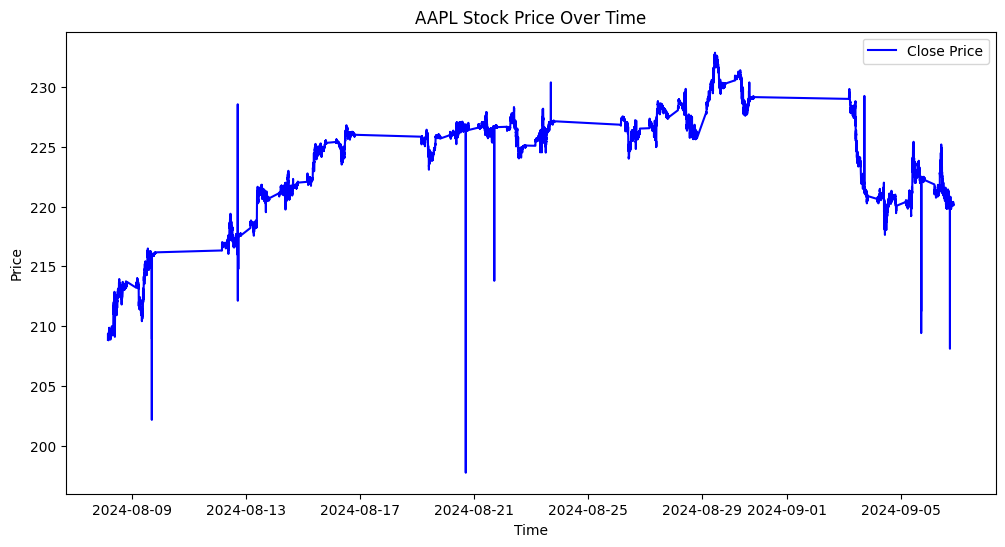

In [22]:
# Visualization: Raw Data Plot
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

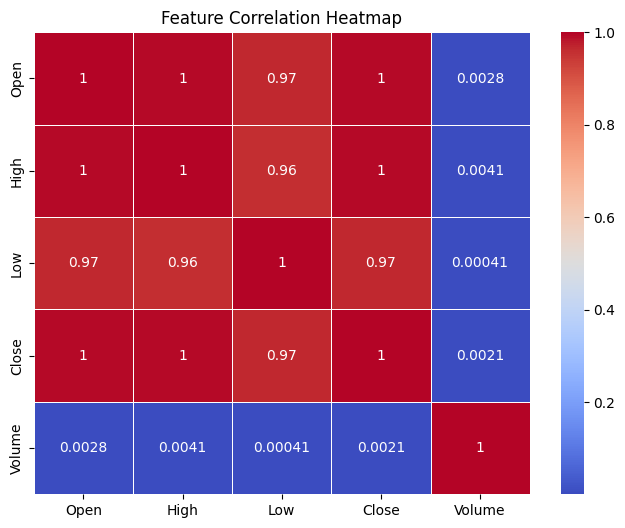

In [23]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [24]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Close']])

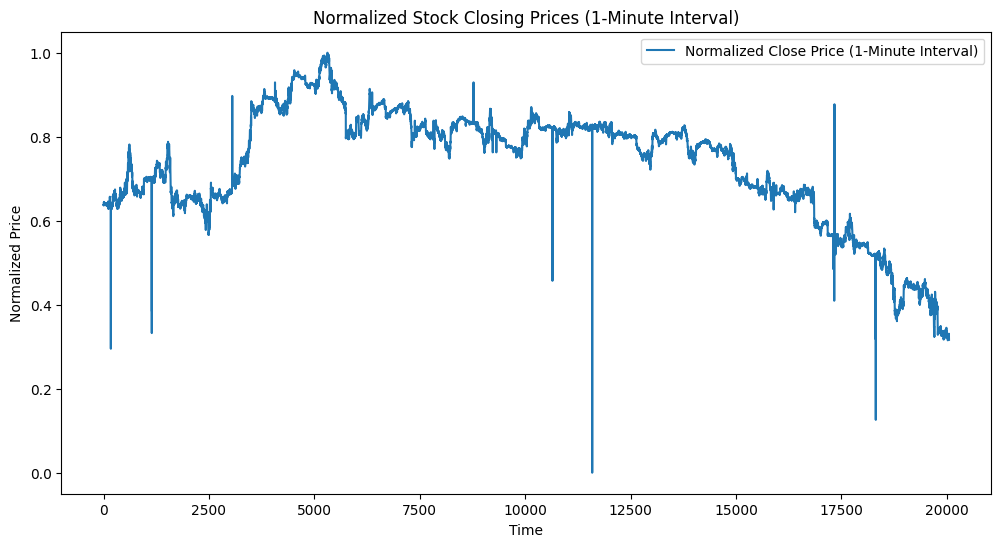

In [25]:
# Visualize the scaled data
plt.figure(figsize=(12, 6))
plt.plot(data_scaled, label='Normalized Close Price (1-Minute Interval)')
plt.title('Normalized Stock Closing Prices (1-Minute Interval)')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [26]:
# Prepare LSTM Data
n_steps = 50
X_train_data, y_train_data = [], []
for i in range(n_steps, len(data_scaled)):
    X_train_data.append(data_scaled[i - n_steps:i, 0])
    y_train_data.append(data_scaled[i, 0])

X_train_data, y_train_data = np.array(X_train_data), np.array(y_train_data)


In [27]:
# Reshape for LSTM input
X_train_data = np.reshape(X_train_data, (X_train_data.shape[0], X_train_data.shape[1], 1))

print(f'Training data shape: {X_train_data.shape}, {y_train_data.shape}')



Training data shape: (20005, 50, 1), (20005,)


In [28]:
# Define LSTM model architecture
data_lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_data.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Compile the model
data_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])


In [30]:
# Train the model
history = data_lstm_model.fit(X_train_data, y_train_data, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - loss: 0.0373 - mean_absolute_percentage_error: 8650.3301 - val_loss: 3.9356e-04 - val_mean_absolute_percentage_error: 3.3426
Epoch 2/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - loss: 0.0037 - mean_absolute_percentage_error: 73341.7969 - val_loss: 3.2665e-04 - val_mean_absolute_percentage_error: 2.9793
Epoch 3/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 0.0032 - mean_absolute_percentage_error: 21347.3047 - val_loss: 3.1288e-04 - val_mean_absolute_percentage_error: 2.6801
Epoch 4/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - loss: 0.0029 - mean_absolute_percentage_error: 90094.3125 - val_loss: 1.5315e-04 - val_mean_absolute_percentage_error: 1.3313
Epoch 5/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - loss: 0.0022 - mean_absolute_percentage_error: 58650.6680 - val_loss: 1.5667e-04 - val_mean_absolute_percentage_error: 1.3998
Epoch 6/50
501/501 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - loss: 0.0018 - mean_absolute_percen

In [31]:
# Prepare test data for prediction
test_data = data_scaled[len(data_scaled) - len(X_train_data):]
X_test = []

for i in range(n_steps, len(test_data)):
    X_test.append(test_data[i - n_steps:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [32]:
# Predict stock prices
data_predictions = data_lstm_model.predict(X_test)
data_predictions = scaler.inverse_transform(data_predictions)

624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step


In [33]:
# Rescale the true values back to the original scale
true_stock_prices = scaler.inverse_transform(data_scaled[n_steps:])

# Evaluate the model
data_lstm_rmse = np.sqrt(mean_squared_error(true_stock_prices[:len(data_predictions)], data_predictions))
print(f'LSTM Model RMSE: {data_lstm_rmse}')




LSTM Model RMSE: 0.7694833337609199


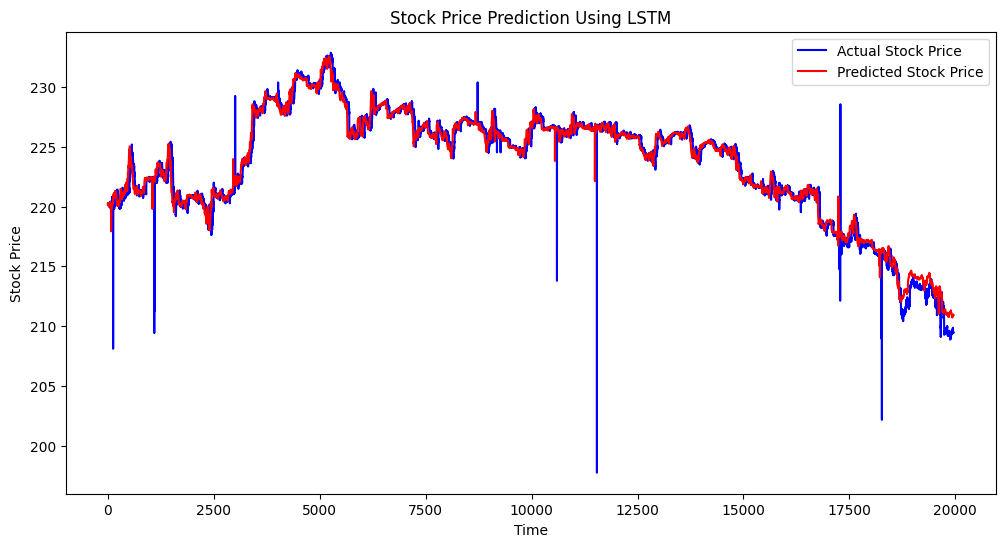

In [34]:
# Plot predictions and true stock prices
plt.figure(figsize=(12, 6))
plt.plot(true_stock_prices[:len(data_predictions)], label='Actual Stock Price', color='blue')
plt.plot(data_predictions, label='Predicted Stock Price', color='red')
plt.title('Stock Price Prediction Using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()